# Advanced Data Splitting and Semantic Chunking

 This notebook implements sophisticated text chunking strategies to prepare the dataset for Named Entity Recognition (NER) model training. We'll evaluate different semantic chunking configurations and create optimally-sized text segments that preserve semantic coherence while fitting within model token limits.

 ## Setup environment and import required libraries for chunking and tokenization

In [1]:
# %%

from notebook_config import DATASETS_DIR, FILES_DIR, MISC_DIR
import pandas as pd
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import tiktoken

from langchain_openai import OpenAIEmbeddings
from langchain_experimental.text_splitter import SemanticChunker
from langchain_text_splitters import TokenTextSplitter

# Initialize tokenizer for counting tokens
encoding = tiktoken.encoding_for_model("gpt-4o")
def count_tokens(text: str) -> int:
    return len(encoding.encode(text))

## Load Preprocessed Dataset

 Load the cleaned dataset prepared for fine-tuning from the previous notebook. This dataset contains:
 - **Cleaned text**: HTML and JSON content has been normalized
 - **Standardized entities**: Entity names without ID metadata
 - **Token counts**: Pre-computed token lengths for each article

 This serves as our foundation for implementing advanced chunking strategies.

In [2]:
# %%

df = pd.read_csv(DATASETS_DIR / "full_data_clean_finetune.csv")
articles = df["text"].tolist()

## Phase 1: Semantic Chunking Configuration Evaluation

 Evaluate different semantic chunking configurations on a small sample to identify optimal parameters:

 **Threshold Strategies Tested:**
 - **Percentile-based**: Uses statistical percentiles (80%, 90%, 95%, 98%) to determine breakpoints
 - **Standard deviation**: Uses mean ± 1.5σ to identify natural text boundaries
 - **Interquartile range**: Uses IQR-based thresholds for robust breakpoint detection

 **Evaluation Metrics:**
 - Chunk count per article
 - Token distribution statistics (min, max, mean, median)
 - Semantic coherence preservation

 This systematic evaluation ensures we choose the most effective chunking strategy for our specific dataset.

In [ ]:
# %%

threshold_configs = [
    ("percentile", 80.0),
    ("percentile", 90.0),
    ("percentile", 95.0),
    ("percentile", 98.0),
    ("standard_deviation", 1.5),
    ("interquartile", 1.5)
]

stats_data, results_json = [], []
for threshold_type, threshold_amount in tqdm(threshold_configs, desc="Configs"):
    splitter = SemanticChunker(
        OpenAIEmbeddings(),
        breakpoint_threshold_type=threshold_type,
        breakpoint_threshold_amount=threshold_amount,
    )

    for i, article in enumerate(articles[:5]):
        docs = splitter.create_documents([article])
        tokens = [count_tokens(doc.page_content) for doc in docs]
        # Collect summary statistics for each chunking config
        stats_data.append({
            "config": f"{threshold_type} {threshold_amount}",
            "article_index": i,
            "num_chunks": len(docs),
            "min_tokens": min(tokens),
            "max_tokens": max(tokens),
            "mean_tokens": sum(tokens) / len(tokens),
            "median_tokens": sorted(tokens)[len(tokens) // 2],
        })
        # Store full chunk details for inspection
        results_json.append({
            "config": f"{threshold_type} {threshold_amount}",
            "article_index": i,
            "original_length": len(article),
            "original_tokens": count_tokens(article),
            "chunks": [
                {
                    "chunk_index": j,
                    "length": len(doc.page_content),
                    "tokens": count_tokens(doc.page_content),
                    "content": doc.page_content,
                }
                for j, doc in enumerate(docs)
            ],
        })

# Save evaluation outputs for later review
# - CSV of summary stats
# - JSON with detailed chunk content
eval_stats_path = MISC_DIR / "semantic_eval_stats_first5.csv"
eval_json_path = MISC_DIR / "semantic_eval_chunks_first5.json"
pd.DataFrame(stats_data).to_csv(eval_stats_path, index=False)
with open(eval_json_path, "w", encoding="utf-8") as f:
    json.dump(results_json, f, indent=2, ensure_ascii=False)
print(f"Saved stats CSV: {eval_stats_path}")
print(f"Saved JSON output: {eval_json_path}")

Configs:   0%|          | 0/6 [00:00<?, ?it/s]

[2025-07-29 16:26:56] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:26:57] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:26:58] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:26:59] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:27:00] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Configs:  17%|█▋        | 1/6 [00:06<00:32,  6.49s/it]

[2025-07-29 16:27:02] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:27:03] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:27:03] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:27:04] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:27:05] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Configs:  33%|███▎      | 2/6 [00:10<00:20,  5.05s/it]

[2025-07-29 16:27:06] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:27:07] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:27:08] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:27:08] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:27:09] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Configs:  50%|█████     | 3/6 [00:14<00:13,  4.53s/it]

[2025-07-29 16:27:10] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:27:11] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:27:12] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:27:12] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:27:13] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Configs:  67%|██████▋   | 4/6 [00:18<00:08,  4.41s/it]

[2025-07-29 16:27:14] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:27:15] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:27:16] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:27:16] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:27:17] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Configs:  83%|████████▎ | 5/6 [00:23<00:04,  4.47s/it]

[2025-07-29 16:27:19] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:27:20] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:27:20] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:27:21] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
[2025-07-29 16:27:22] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Configs: 100%|██████████| 6/6 [00:27<00:00,  4.62s/it]

Saved stats CSV: c:\Users\User\Workspace\work_practice\interview\toptal\take-home-assignment\files\misc\semantic_eval_stats_first5.csv
Saved JSON output: c:\Users\User\Workspace\work_practice\interview\toptal\take-home-assignment\files\misc\semantic_eval_chunks_first5.json


## Configuration Comparison Visualization

 Create comprehensive visualizations to compare chunking configurations across multiple dimensions:

 **Metrics Visualized:**
 - **Median tokens per chunk**: Central tendency of chunk sizes
 - **Mean tokens per chunk**: Average chunk size with outlier sensitivity
 - **Chunks per article**: Granularity of text segmentation
 - **Chunk distribution**: Spread and variability of chunk sizes

 These visualizations help identify the optimal balance between semantic coherence and practical token limits for model training.

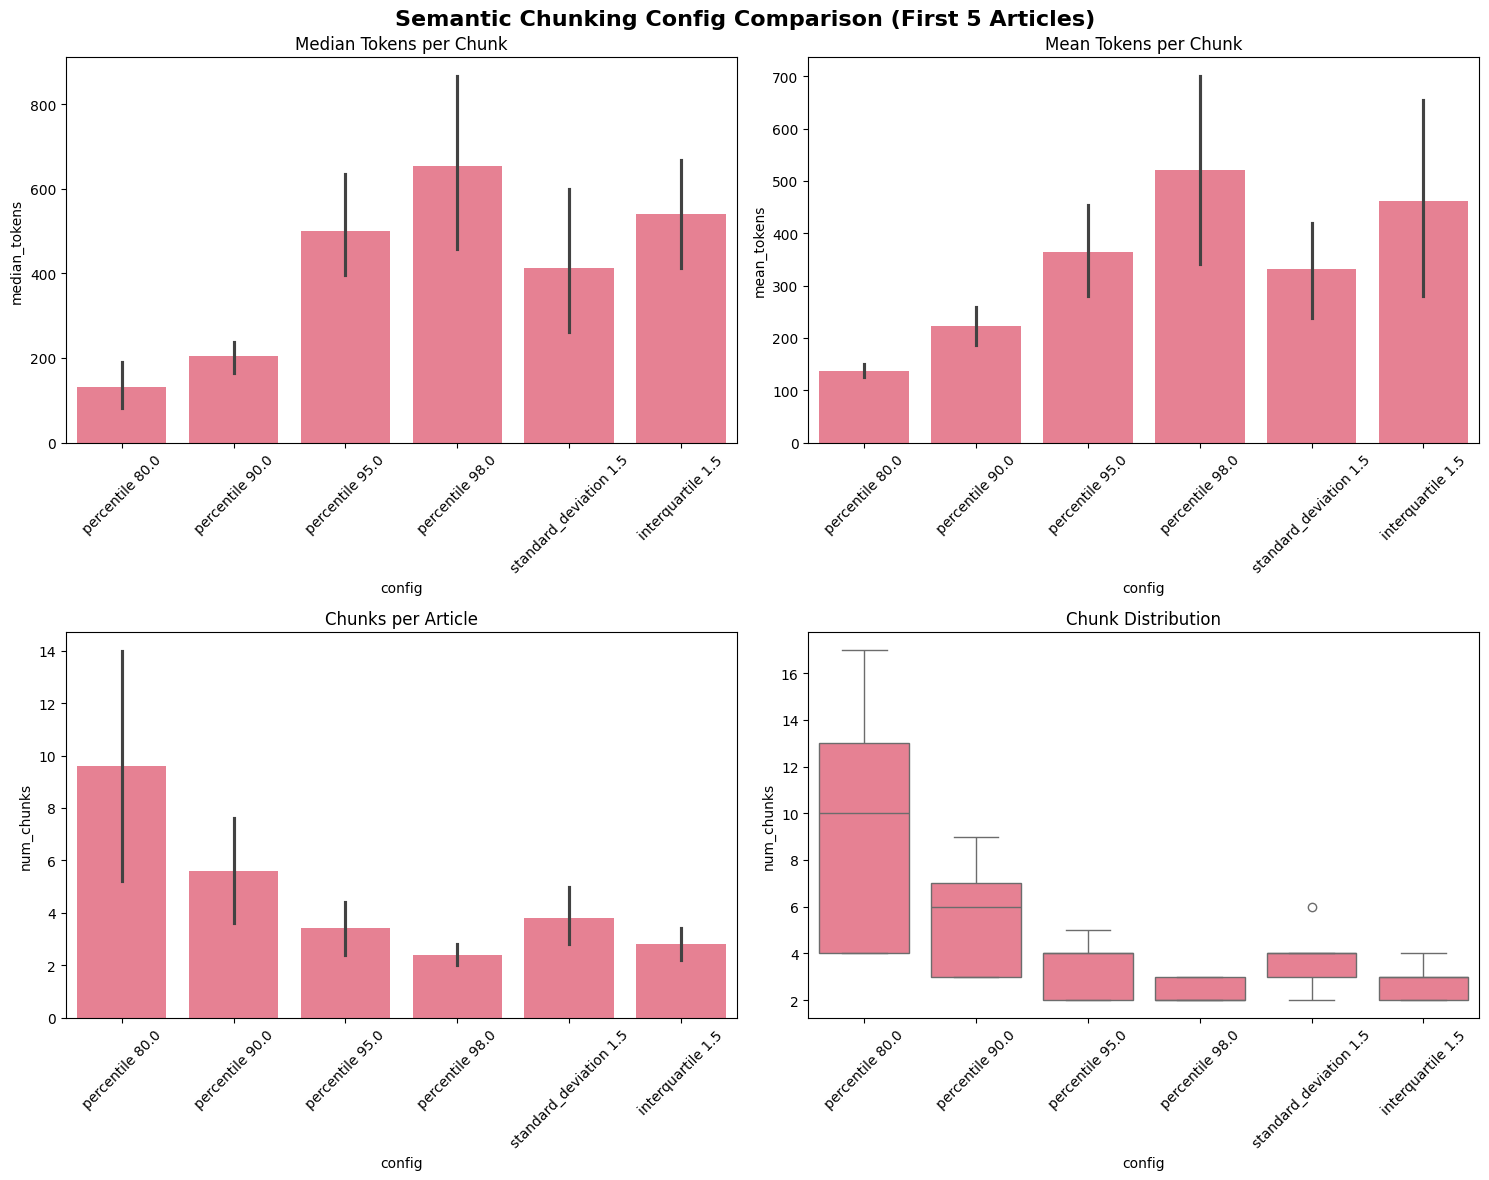

Saved plot: c:\Users\User\Workspace\work_practice\interview\toptal\take-home-assignment\files\misc\semantic_chunking_eval_first5_plot.png


In [ ]:
# %%

stats_df = pd.DataFrame(stats_data)
plt.style.use("default")
sns.set_palette("husl")
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(
    "Semantic Chunking Config Comparison (First 5 Articles)",
    fontsize=16,
    fontweight="bold",
)

sns.barplot(data=stats_df, x="config", y="median_tokens", ax=axes[0, 0])
axes[0, 0].set_title("Median Tokens per Chunk")
axes[0, 0].tick_params(axis="x", rotation=45)

sns.barplot(data=stats_df, x="config", y="mean_tokens", ax=axes[0, 1])
axes[0, 1].set_title("Mean Tokens per Chunk")
axes[0, 1].tick_params(axis="x", rotation=45)

sns.barplot(data=stats_df, x="config", y="num_chunks", ax=axes[1, 0])
axes[1, 0].set_title("Chunks per Article")
axes[1, 0].tick_params(axis="x", rotation=45)

sns.boxplot(data=stats_df, x="config", y="num_chunks", ax=axes[1, 1])
axes[1, 1].set_title("Chunk Distribution")
axes[1, 1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plot_path = MISC_DIR / "semantic_chunking_eval_first5_plot.png"
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved plot: {plot_path}")

## Phase 2: Full Corpus Processing with Optimal Configuration

 Apply the best-performing chunking configuration to the entire dataset:

 **Two-Stage Processing:**
 1. **Semantic chunking**: Uses percentile-based threshold (80%) to create semantically coherent segments
 2. **Token-based splitting**: Further divides semantic chunks into fixed 500-token segments for NER labeling

 **Benefits of This Approach:**
 - Preserves semantic boundaries and context
 - Ensures consistent token lengths for model training
 - Maintains entity relationships within chunks
 - Optimizes memory usage and batch processing efficiency

In [ ]:
# %%

best_type, best_amount = "percentile", 80.0
splitter = SemanticChunker(
    OpenAIEmbeddings(),
    breakpoint_threshold_type=best_type,
    breakpoint_threshold_amount=best_amount,
)
text_splitter = TokenTextSplitter(
    model_name="gpt-4o", chunk_size=500, chunk_overlap=0
)

all_chunks = []
for i, article in enumerate(tqdm(articles, desc="Processing full corpus")):
    docs = splitter.create_documents([article])
    chunks = text_splitter.split_documents(docs)
    orig_row = df.iloc[i].to_dict()
    for j, chunk in enumerate(chunks):
        row = orig_row.copy()
        row.update({
            "chunk_id": f"{i}_{j}",
            "original_article_index": i,
            "chunk_index": j,
            "text": chunk.page_content,
            "num_tokens": count_tokens(chunk.page_content),
            "num_chunks_in_original": len(docs),
            "threshold_type": best_type,
            "threshold_amount": best_amount,
        })
        all_chunks.append(row)
# Save the complete chunked dataset
output_df = pd.DataFrame(all_chunks)
final_csv = DATASETS_DIR / "semantic_split_complete_dataset.csv"
output_df.to_csv(final_csv, index=False)

print(f"✅ Saved full processed dataset: {final_csv}")
print(f"Total chunks: {len(output_df)}")
print(f"Chunks per article (mean): {len(output_df)/len(articles):.2f}")
print(
    f"Token stats — Min: {output_df.num_tokens.min()}, Max: {output_df.num_tokens.max()}, Mean: {output_df.num_tokens.mean():.1f}"
)

Processing full corpus:   0%|          | 0/10 [00:00<?, ?it/s]

[2025-07-29 16:27:25] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Processing full corpus:  10%|█         | 1/10 [00:01<00:09,  1.00s/it]

[2025-07-29 16:27:26] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Processing full corpus:  20%|██        | 2/10 [00:01<00:07,  1.07it/s]

[2025-07-29 16:27:27] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Processing full corpus:  30%|███       | 3/10 [00:02<00:05,  1.33it/s]

[2025-07-29 16:27:27] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Processing full corpus:  40%|████      | 4/10 [00:03<00:04,  1.37it/s]

[2025-07-29 16:27:28] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Processing full corpus:  50%|█████     | 5/10 [00:03<00:03,  1.53it/s]

[2025-07-29 16:27:29] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Processing full corpus:  60%|██████    | 6/10 [00:04<00:02,  1.38it/s]

[2025-07-29 16:27:29] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Processing full corpus:  70%|███████   | 7/10 [00:05<00:02,  1.43it/s]

[2025-07-29 16:27:30] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Processing full corpus:  90%|█████████ | 9/10 [00:05<00:00,  1.98it/s]

[2025-07-29 16:27:31] INFO in _client: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Processing full corpus: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]

✅ Saved full processed dataset: c:\Users\User\Workspace\work_practice\interview\toptal\take-home-assignment\files\datasets\semantic_split_complete_dataset.csv
Total chunks: 82
Chunks per article (mean): 8.20
Token stats — Min: 5, Max: 500, Mean: 131.2


## Final Token Distribution Analysis

 Visualize the token distribution in the final chunked dataset to validate our chunking strategy:

 **Key Insights:**
 - **Distribution shape**: Confirms chunks are appropriately sized for model training
 - **Outlier detection**: Identifies any chunks that are too long or too short
 - **Model compatibility**: Ensures chunks fit within typical transformer model sequence limits
 - **Training efficiency**: Validates that chunk sizes support effective batch processing

 This analysis ensures our chunked dataset is optimally prepared for NER model training and evaluation.

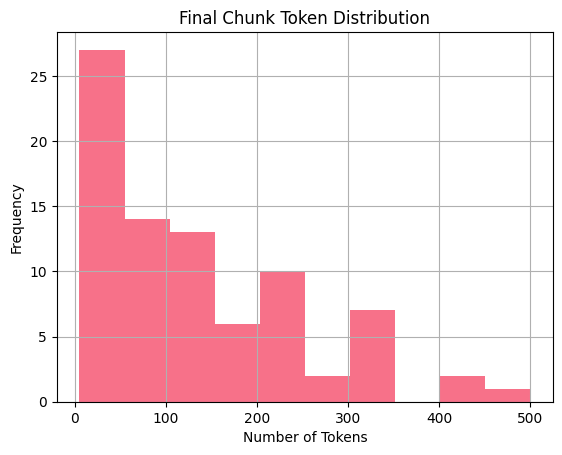

In [ ]:
# %%

output_df.num_tokens.hist()
plt.title('Final Chunk Token Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()